# Initial Sales Prediction Project

## Librerías y Cargado de datos

Primero, se importan las librerías y opciones a utilizar en el presente trabajo

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, chi2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from math import sqrt

import warnings
warnings.filterwarnings("ignore")

Se crea el dataframe y se ven los primeros 10 valores

In [2]:
df = pd.read_excel('Datos_201901_202009.xlsx')
df.head(10)

,CAMPAÑA,GRUPO_1,GRUPO_2,GRUPO_3,GRUPO_4,GRUPO_5,GRUPO_6,GRUPO_7,GRUPO_8,GRUPO_9,GRUPO_10,PEDIDOS_TOTALES
0,201901,6492,6062,2961,1652,1190,89,31,410,15,43,54113
1,201902,4757,3618,2089,855,399,54,13,19,9,20,43091
2,201903,5047,3031,1018,309,157,63,12,7,8,10,50112
3,201904,6227,4586,2056,569,197,94,23,10,7,11,49522
4,201905,5738,4504,2710,525,114,54,21,8,10,7,51854
5,201906,7182,5702,2684,703,195,142,23,22,15,7,54349
6,201907,7159,5800,3921,1313,637,232,42,19,25,31,56634
7,201908,6502,4876,3169,542,159,73,33,10,10,16,56826
8,201909,6725,5394,3375,1324,219,110,27,20,9,16,55058
9,201910,7452,5996,3983,1679,1421,463,40,60,19,13,59947


## Análisis estadístico y exploratorio

Se realiza un pequeño resumen estadístico

In [3]:
df.describe()

,CAMPAÑA,GRUPO_1,GRUPO_2,GRUPO_3,GRUPO_4,GRUPO_5,GRUPO_6,GRUPO_7,GRUPO_8,GRUPO_9,GRUPO_10,PEDIDOS_TOTALES
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,201941.333333,6423.407407,5044.185185,2922.037037,939.037037,416.074074,232.666667,33.814815,47.370370,35.444444,22.074074,55574.814815
std,46.104397,1075.220666,998.678051,1069.612528,577.807360,412.075136,255.798148,31.527811,84.199008,87.200623,21.845482,6201.122641
min,201901.000000,4328.000000,3031.000000,1018.000000,100.000000,37.000000,36.000000,3.000000,1.000000,2.000000,6.000000,43091.000000
25%,201907.500000,5836.500000,4436.000000,2072.500000,533.500000,152.500000,81.000000,17.500000,10.000000,8.500000,11.000000,50666.000000
50%,201914.000000,6502.000000,5200.000000,3112.000000,759.000000,219.000000,136.000000,27.000000,19.000000,15.000000,15.000000,56072.000000
75%,202002.500000,7185.000000,5695.000000,3750.500000,1359.000000,517.500000,284.500000,39.500000,37.500000,23.000000,23.500000,59168.500000
max,202009.000000,8783.000000,6990.000000,4894.000000,2013.000000,1529.000000,1110.000000,172.000000,410.000000,458.000000,105.000000,66863.000000


Se verifican valores nulos y duplicados

In [4]:
df.isnull().sum()

CAMPAÑA            0
GRUPO_1            0
GRUPO_2            0
GRUPO_3            0
GRUPO_4            0
GRUPO_5            0
GRUPO_6            0
GRUPO_7            0
GRUPO_8            0
GRUPO_9            0
GRUPO_10           0
PEDIDOS_TOTALES    0
dtype: int64

In [5]:
df.duplicated().any()

False

De manera breve se hace un análisis exploratorio de los datos para conocer sus distribuciones y outliers con la ayuda de matplotlib

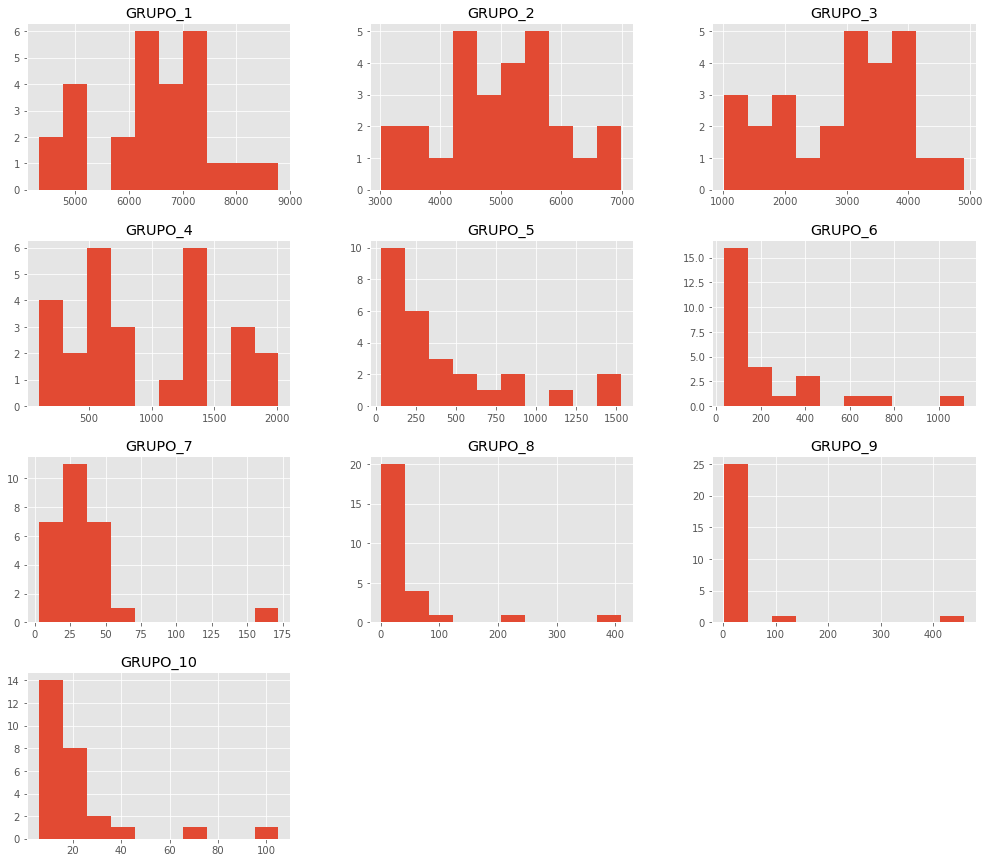

In [6]:
num_bins = 10
df.iloc[:,1:11].hist(bins = num_bins, figsize=(17,15))
plt.show()

Se puede apreciar que en los primeros 3 grupos la distribución se tiende a aproximar a una normal por la concentración de sus datos al centro. Para los grupos 5 al 10 se puede notar que los datos se concentran más a la izquierda, notando que para esos grupos durante las distintas campañas sus pedidos iniciales suelen ser pocos

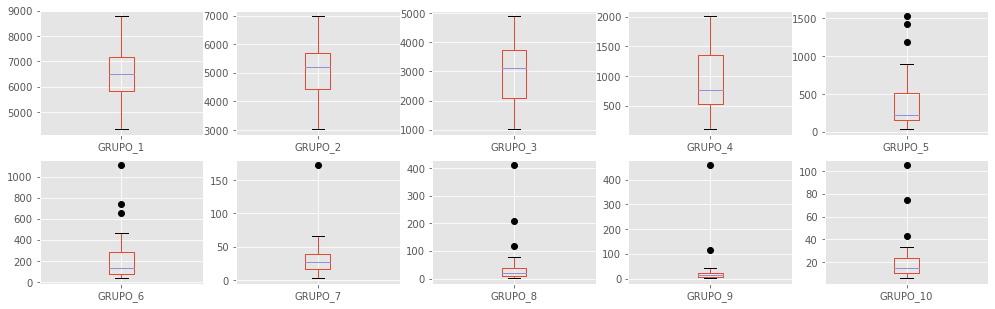

In [7]:
fig = plt.figure(figsize = (17,16))
ax = fig.gca()
df.iloc[:,1:11].rename(columns=lambda x: str(x)).plot(ax=ax, kind= 'box', subplots=True, layout=(6,5), sym='black')
plt.show()

Mediante los boxplots se puede apreciar que existen outliers, específicamente en los grupos del 5 al 10. Para todos estos casos sobrepasan el umbral máximo conformado por el bigote mayor.

Para relacionar las variables predictoras con la target se realizan scatterplots con la ayuda de seaborn regplot y un bucle para los subplots. Estos gráficos nos podrán indicar si es que hay una tendencia lineal tomando las variables por sí solas.

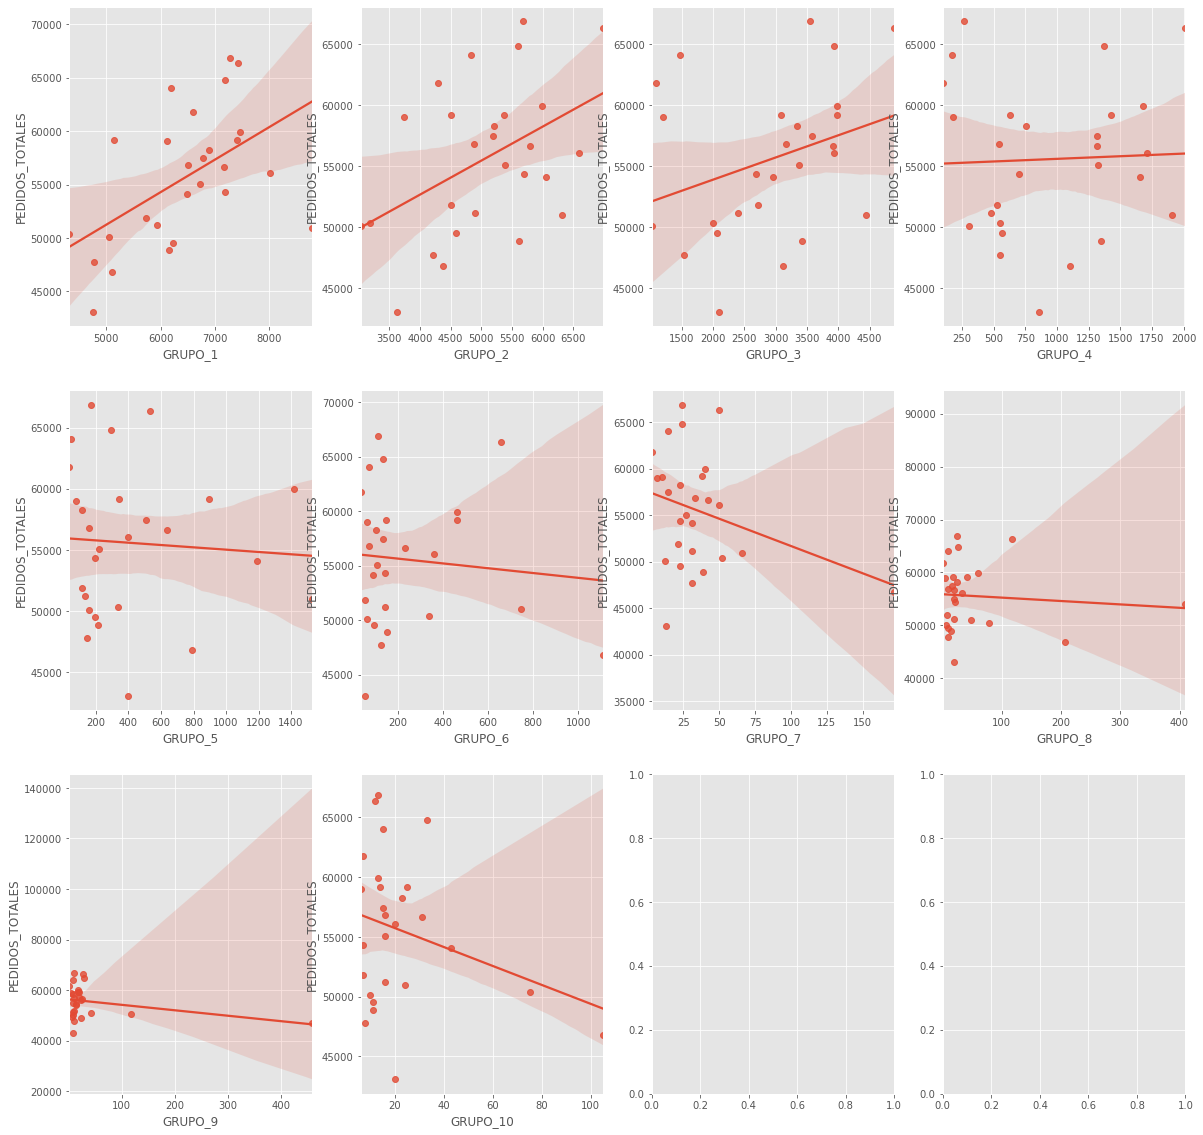

In [8]:
f, axs = plt.subplots(3, 4, figsize=(20,20))
i = 0
j = 0
counter = 0
for category in df.iloc[:,1:11].columns.tolist():
        i = counter // 4
        j = counter % 4
        counter= counter + 1
        sns.regplot(data=df, y='PEDIDOS_TOTALES', x=category, ax=axs[i,j])

Como se aprecia, no existen indicios altos para creer que los pedidos iniciales por los grupos tengan una relación lineal con los pedidos totales por la línea de ajuste y la distribución de los datos. Asimismo, se ve que los intervalos de confianza llegan a ser muy amplios para los últimos 5 grupos, lo que daría indicios a una relación no lineal.

Finalmente, se hace un heatmap con seaborn para ver las correlaciones de las variables predictoras

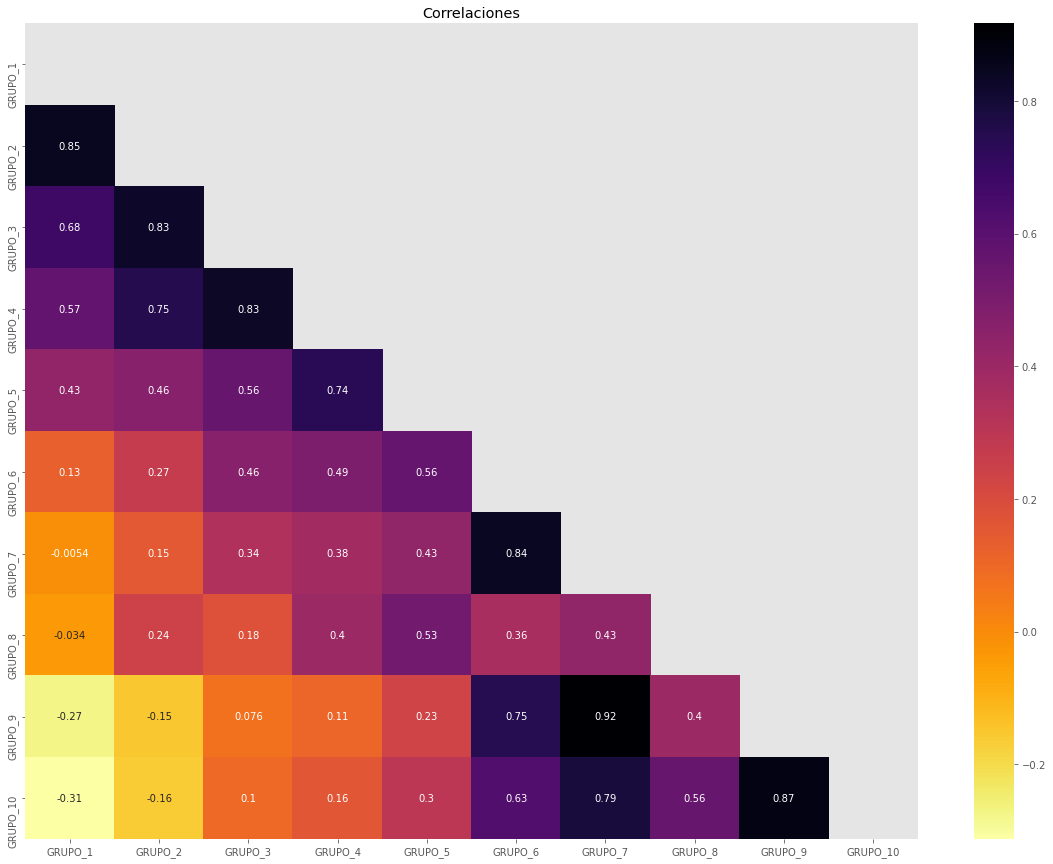

In [9]:
plt.rcParams['figure.figsize'] = (20, 15)

data_corr = df.iloc[:,1:11].corr()

mask = np.triu(np.ones_like(data_corr, dtype=bool))

sns.heatmap(data_corr, annot = True, mask=mask, cmap="inferno_r")
plt.title('Correlaciones')
plt.show()

Se ve una fuerte correlación entre los pedidos iniciales de los grupos 1, 2 y 3. El grupo 7 y el 6. Por último, el grupo 9 y el 19

También, se describen las principales variables correlacionadas con la target. Se puede notar que los primeros 3 grupos presentan una correlación positiva medianamente elevada.

In [10]:
corr = df.iloc[:,1:12].corr()
print (corr['PEDIDOS_TOTALES'].sort_values(ascending=False)[:10], '\n')

PEDIDOS_TOTALES    1.000000
GRUPO_1            0.529104
GRUPO_2            0.447351
GRUPO_3            0.312778
GRUPO_4            0.040089
GRUPO_5           -0.062975
GRUPO_8           -0.087218
GRUPO_6           -0.091109
GRUPO_10          -0.279435
GRUPO_7           -0.298313
Name: PEDIDOS_TOTALES, dtype: float64 



## Elección de Modelo

Para elegir el modelo primero se hará uso de la librería sckiti-learn para dividir los datos en test y train

In [11]:
X = df.iloc[:,1:11]
y = df.iloc[:,11]
X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=0) 

Asimismo, se usará la validación cruzada (K-Folds cross-validator) entre algunos modelos que se utilizan para resolver el problema de regresión como el actual. Se definirá el num_folds como 10 que determina en cuántos 'pliegues' se dividirá el test y el train en cada iteración a partir de los datos proporcionados.

Los modelos a comparar son:
- Regresión Linear
- Regresión Lasso
- Regresión Elastic Net
- Regressión por k vecinos más próximos
- Regresión por Árbol de Decisión
- Regresión por Máquinas de vectores de soporte

Se debe mencionar, también, que las comparaciones se harán con los hiperparámetros default de cada algoritmo

In [12]:
num_folds = 10


models = []
models.append(('LiR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('k-NN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVM', SVR()))

Primero, se comparan usando como referencia el Raíz del error cuadrático medio.

In [13]:
results = []
names = []
scoring = 'neg_root_mean_squared_error'
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():,.3f} ({cv_results.std():,.3f})")

LiR: -12,842.975 (14,388.654)
LASSO: -12,842.243 (14,386.754)
EN: -12,712.004 (14,173.252)
k-NN: -6,010.759 (2,200.760)
CART: -8,994.896 (4,586.924)
SVM: -5,505.801 (2,803.116)


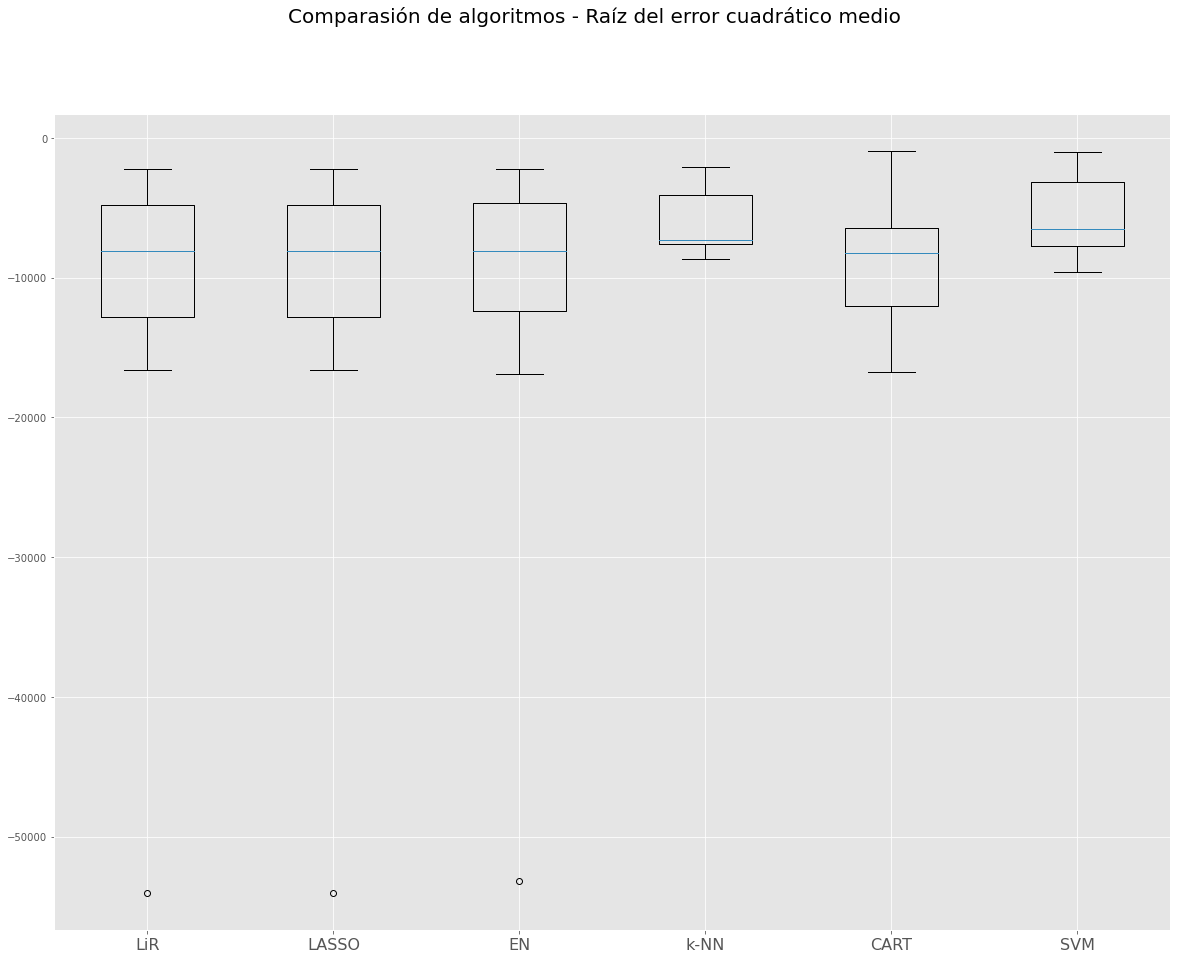

In [14]:
fig = plt.figure()
fig.suptitle('Comparasión de algoritmos - Raíz del error cuadrático medio', fontsize=20)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names,fontsize=16)
plt.show()

Juzgando por la concentración de las métricas y su media se puede notar que los algorítmos que se comportan mejor (se acercan a un valor nulo más que otros) son los de KNeighborsRegressor y Support Vector Regression

Ahora, se comparará por el Error absoluto medio

In [15]:
scoring = 'neg_mean_absolute_error'
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():,.3f} ({cv_results.std():,.3f})")

LiR: -10,875.004 (10,285.727)
LASSO: -10,874.511 (10,284.204)
EN: -10,766.516 (10,117.456)
k-NN: -5,531.220 (2,129.674)
CART: -7,560.500 (3,749.645)
SVM: -5,134.644 (2,615.741)


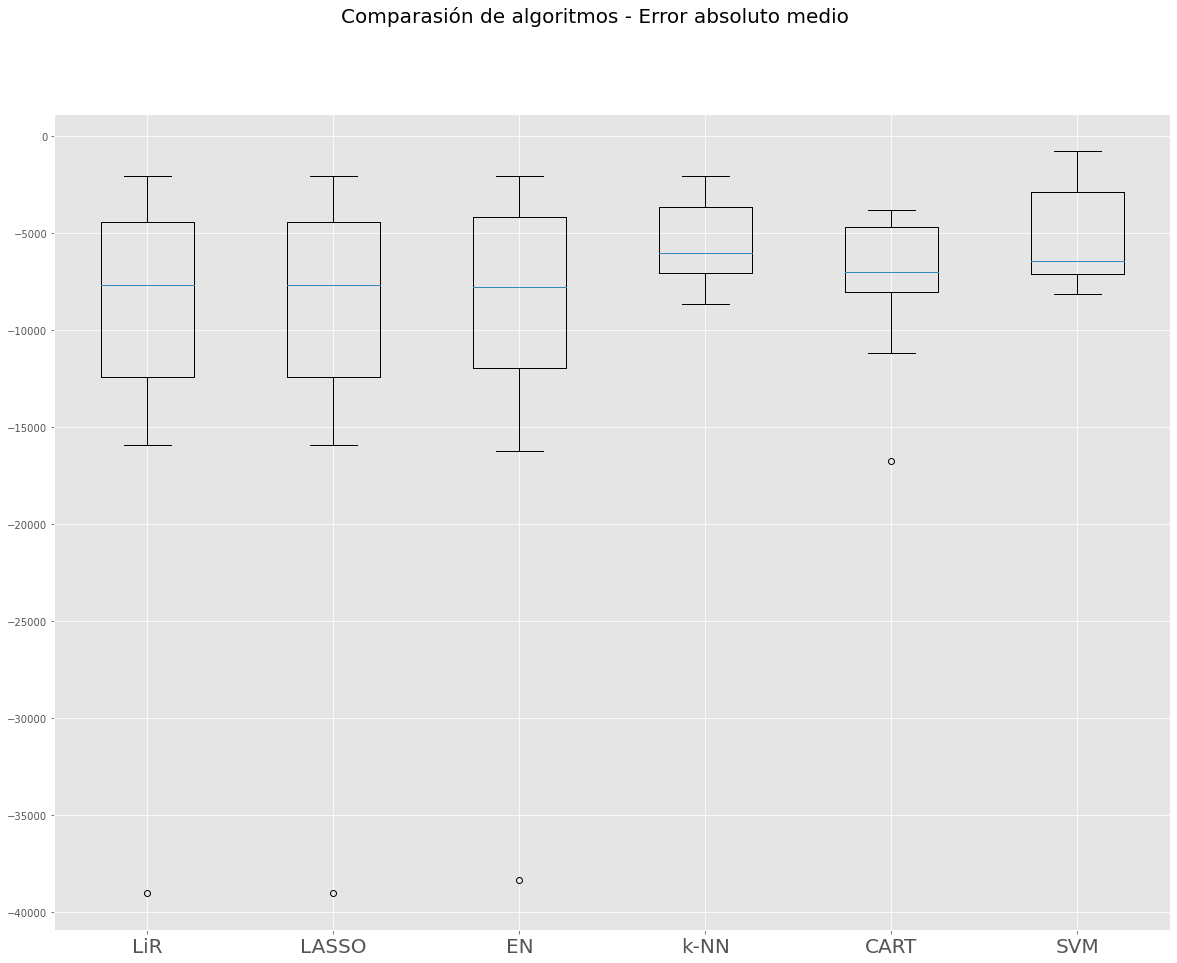

In [16]:
fig = plt.figure()
fig.suptitle('Comparasión de algoritmos - Error absoluto medio',fontsize=20)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names,fontsize=20)
plt.show()

De la misma forma, los algoritmos que se comportan mejor son los de KNeighborsRegressor y Support Vector Regression. Se aprecia una mejora de DecisionTreeRegressor.

### KNeighborsRegressor

Para el presente trabajo se optó por utilizar KNeighborsRegressor al presentar un mejor performance en las métricas

Asimismo, a diferencia de una regresión lineal, este tiene un poder predictivo mayor cuando los datos no siguen un comportamiento lienal con la variable target o realizar una combinación lineal de las variables predictivas no restulará en el mejor ajuste de modelo.

Ahora, para la definición del hiperparámetro del KNeighborsRegressor, el número de vecinos, se utilizará validación cruzada para la división de los train y test con un parámetro de 10 'pliegues' como se hizo anteriormente. Con esto, se iterará con valores de 1 a 19 vecinos (k) para conseguir el menor error cuadrático medio.

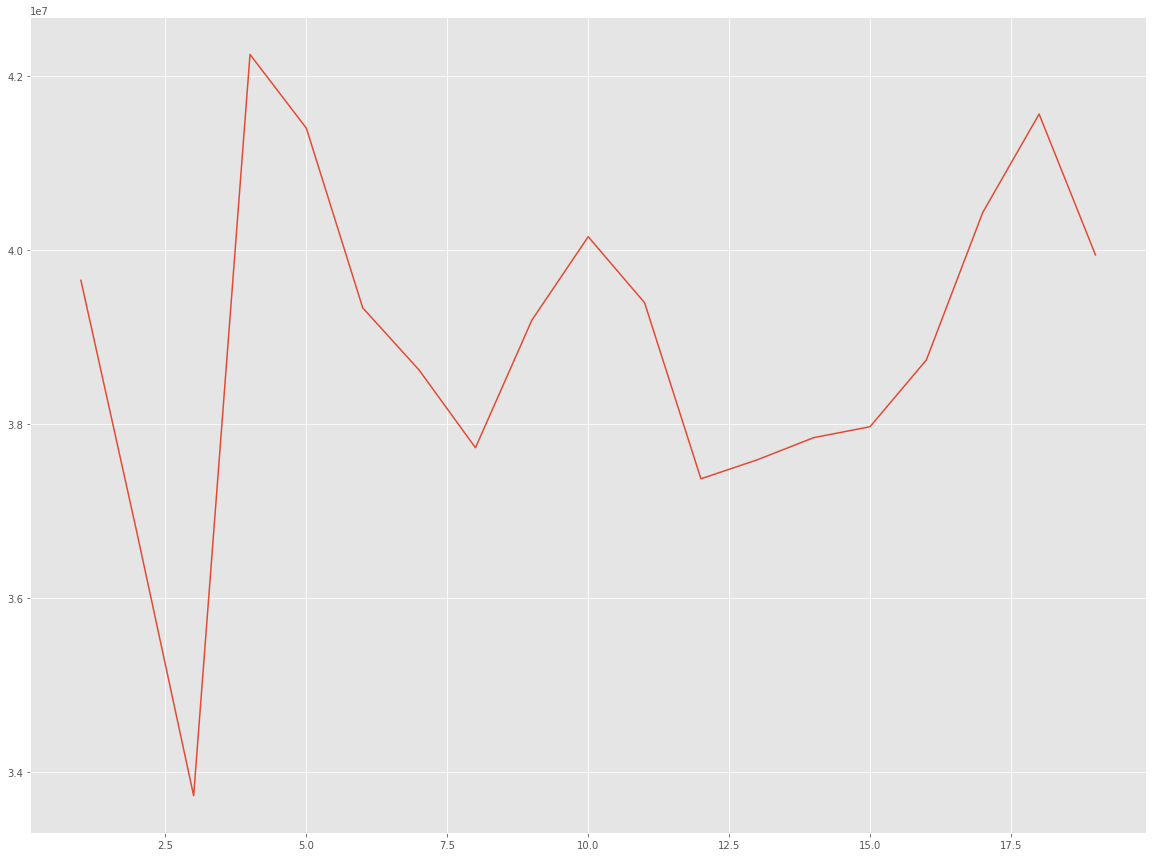

In [31]:
kfold = KFold(n_splits=10)
error = []
for k in range(1,20):
    knn = KNeighborsRegressor(n_neighbors=k)
    y_pred = cross_val_predict(knn, X, y, cv=kfold)
    error.append(mean_squared_error(y,y_pred)) 
plt.plot(range(1,20),error)

Según el criterio del codo, el k óptimo es 3

Usando GridSearchCV se puede confirmar lo anterior mediante la misma métrica de comparación. El número de vecinos óptimos es 3

In [44]:
params = {'n_neighbors':[1,2,3,4,5,6,7,8,9]}

knn = KNeighborsRegressor()
kfold = KFold(n_splits=10)

model = GridSearchCV(knn, params, cv=kfold, scoring='neg_mean_squared_error')
model.fit(X,y)
model.best_params_

{'n_neighbors': 3}

Ahora, definido el hiperparámetro, se procederá a calcular las predicciones haciendo uso de la validación cruzada en la división de test y train con KFold, usado anteriormente.

In [45]:
knn = KNeighborsRegressor(n_neighbors=3)
y_pred = cross_val_predict(knn, X, y, cv=kfold)

In [56]:
colormap = np.array(['r', 'g'])

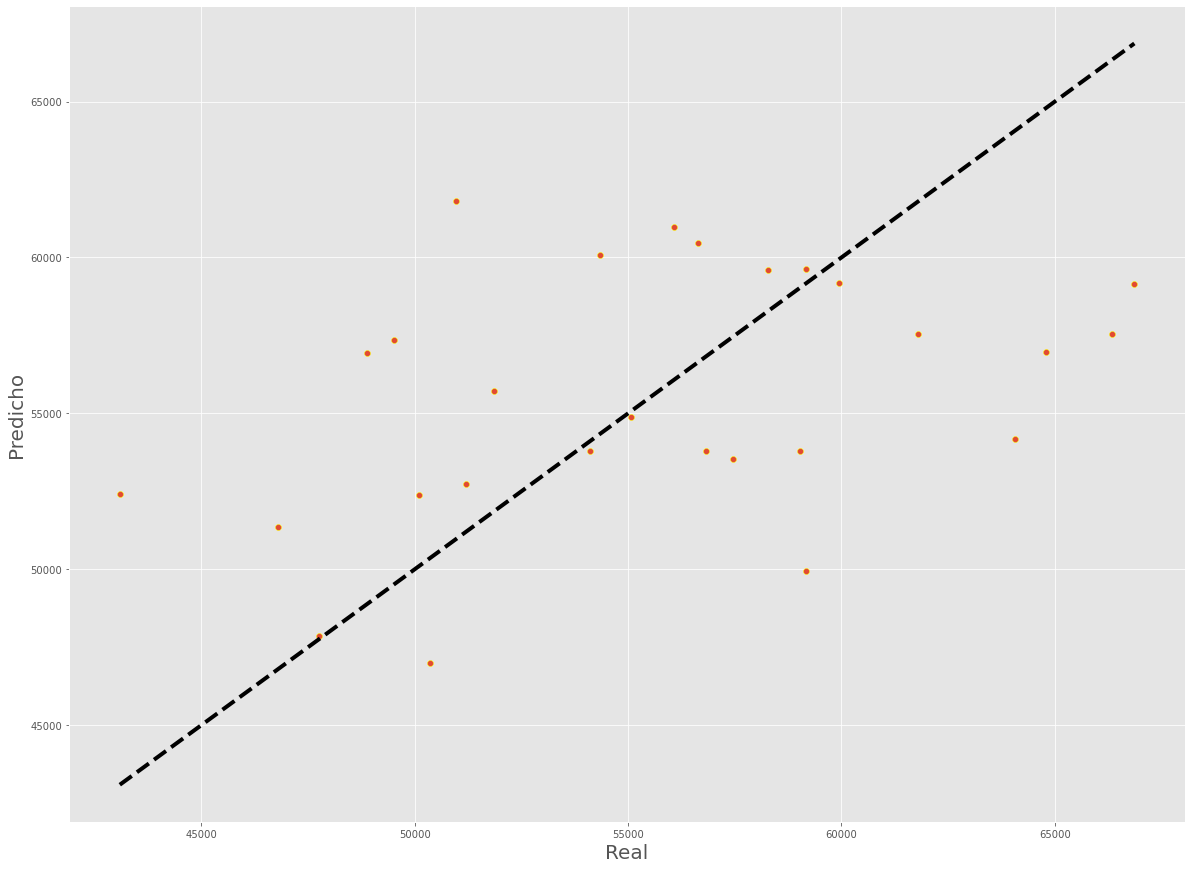

In [58]:
fig, ax = plt.subplots()
ax.scatter(y, y_pred, edgecolors=(1, 1, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=4)
ax.set_xlabel("Real", size=20)
ax.set_ylabel("Predicho",size=20)
plt.show()


Si bien, el ajuste no es perfecto ni elevado, se aprecia que la linea logra atravesar los puntos en la distancia más cerca posible y, notando por los ejes, no hay una gran diferencia en la magnitud de los valores

In [21]:
kfold = KFold(n_splits=10)
y_pred = cross_val_predict(knn, X, y, cv=kfold)
print('Raíz del error cuadrático medio: ',sqrt(mean_squared_error(y,y_pred)))
print('Error cuadrático medio: ',mean_squared_error(y,y_pred))
print('R_2: ',r2_score(y,y_pred))

Raíz del error cuadrático medio:  5807.46558549846
Error cuadrático medio:  33726656.52674898
R_2:  0.08919990992500693


Ahora se trabajará el mismo algoritmo, pero usando una pipeline que permita estandarizar los datos. En este caso se uso el StandardScaler().

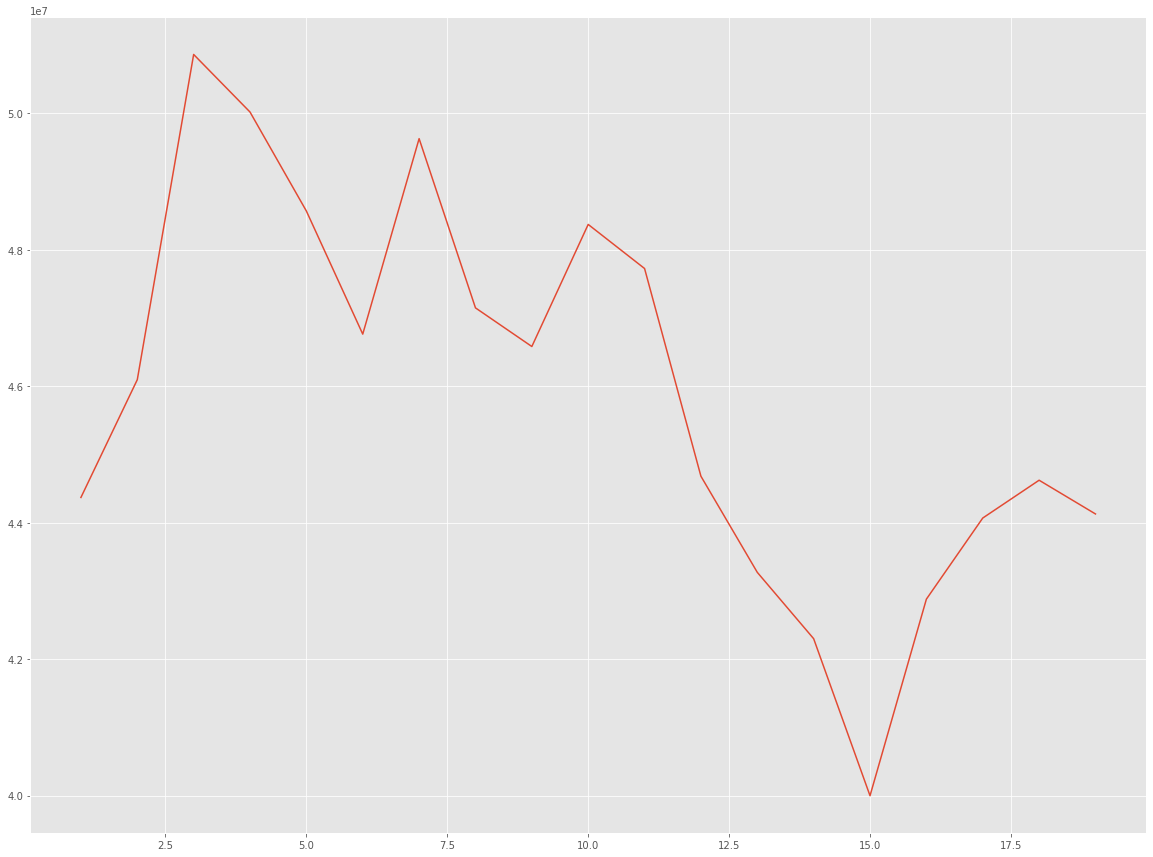

In [22]:
error = []
for k in range(1,20):
    reg_pipeline = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=k))
    y_pred = cross_val_predict(reg_pipeline, X, y, cv=kfold)
    error.append(mean_squared_error(y,y_pred))
plt.plot(range(1,20),error)

En este caso, se puede apreciar que el número de vecinos aumento abruptamente, ahora son 15.

In [23]:
reg_pipeline = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=15))

In [24]:
y_pred_std = cross_val_predict(reg_pipeline, X, y, cv=kfold)

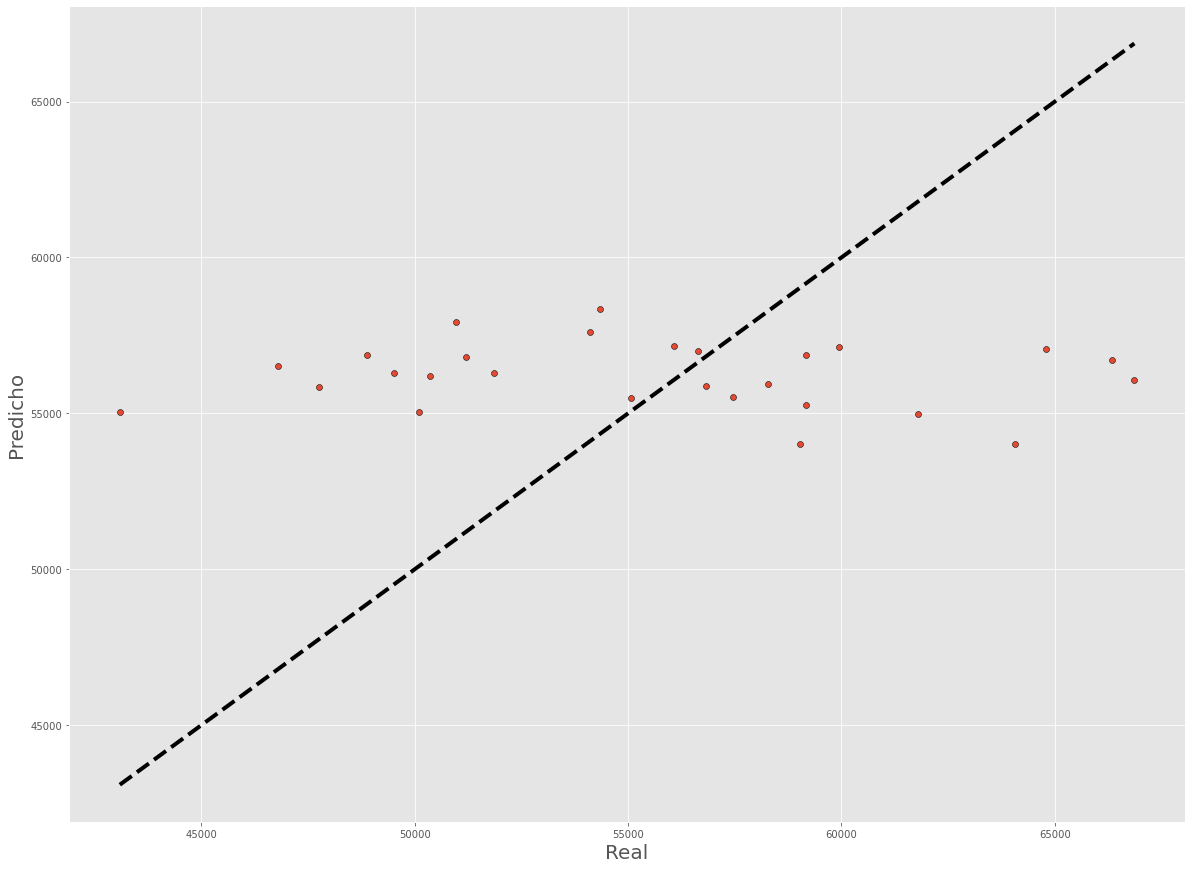

In [25]:
fig, ax = plt.subplots()
ax.scatter(y, y_pred_std, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=4)
ax.set_xlabel("Real", size=20)
ax.set_ylabel("Predicho",size=20)
plt.show()

In [26]:
y_pred = cross_val_predict(reg_pipeline, X, y, cv=kfold)
print('Raíz del error cuadrático medio: ',sqrt(mean_squared_error(y,y_pred_std)))
print('Error cuadrático medio: ',mean_squared_error(y,y_pred_std))
print('R_2: ',r2_score(y,y_pred_std))

Raíz del error cuadrático medio:  6324.477516753277
Error cuadrático medio:  39999015.85991769
R_2:  -0.08018733547543322


Es interesante notar que al realizar el escalamiento los resultados del modelo tienen peores métricas: el RMSE ahora es 6324.478 y antes era 5807.4656.

Esto se podría explicar porque KNN es un algoritmo basado en distancias y que justamente las variables más 'desproporcionadas' como los grupos 1, 2 y 3 son las que más aportan al modelo, por lo que, si se hace el escalamiento se tiende a reducir el desempeño del modelo.

#### Comparando con Regresión Lineal

In [27]:
LiR = LinearRegression()
kfold = KFold(n_splits=10)

y_pred2 = cross_val_predict(LiR, X, y, cv=kfold)
print('Raíz del error cuadrático medio: ',sqrt(mean_squared_error(y,y_pred2)))
print('Error cuadrático medio: ',mean_squared_error(y,y_pred2))
print('R_2: ',r2_score(y,y_pred2))

Raíz del error cuadrático medio:  19055.821902734588
Error cuadrático medio:  363124348.3887393
R_2:  -8.806299327612816


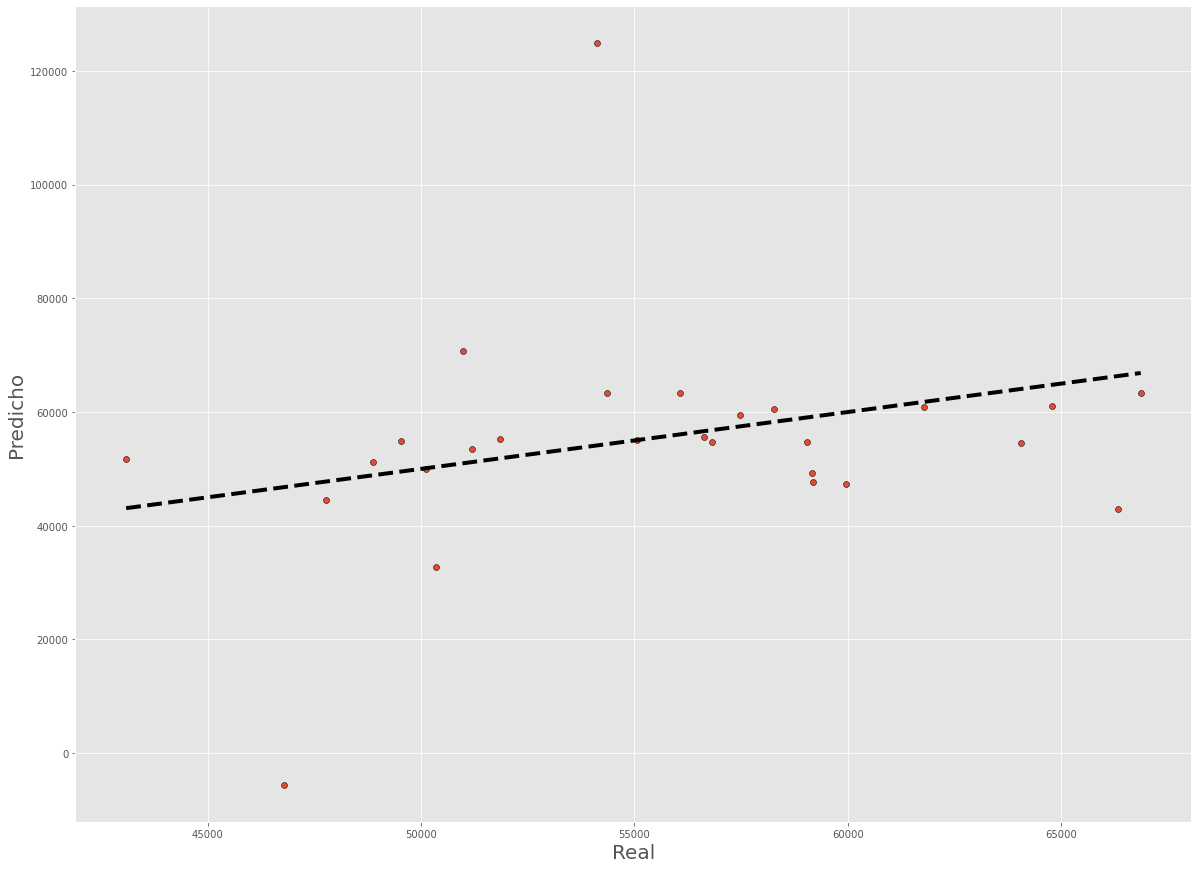

In [28]:
fig, ax = plt.subplots()
ax.scatter(y, y_pred2, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=4)
ax.set_xlabel("Real", size=20)
ax.set_ylabel("Predicho",size=20)
plt.show()

Se puede apreciar, tanto en las métricas, como en el gráfico de ajuste que la regresión lineal base con la misma validación cruzada no resulta tan precisa ni tan predictiva como el KNNRegressor: existen puntos muy alejados de la línea de ajuste y las métricas de error son mayores.

In [29]:
LiR_pipeline = make_pipeline(StandardScaler(), LinearRegression())

y_pred2_std = cross_val_predict(LiR_pipeline, X, y, cv=kfold)
print('Raíz del error cuadrático medio: ',sqrt(mean_squared_error(y,y_pred2_std)))
print('Error cuadrático medio: ',mean_squared_error(y,y_pred2_std))
print('R_2: ',r2_score(y,y_pred2_std))

Raíz del error cuadrático medio:  19055.821902734602
Error cuadrático medio:  363124348.38873976
R_2:  -8.806299327612829


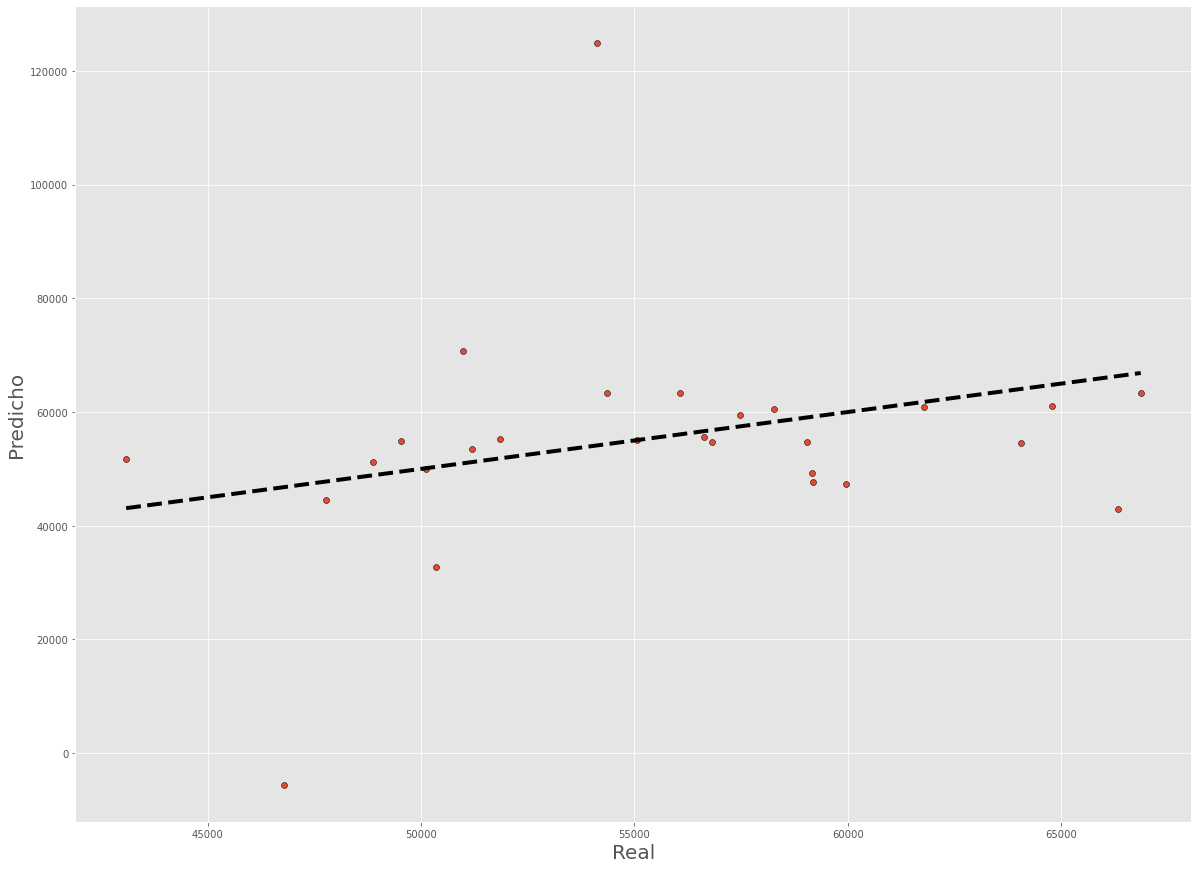

In [30]:
fig, ax = plt.subplots()
ax.scatter(y, y_pred2_std, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=4)
ax.set_xlabel("Real", size=20)
ax.set_ylabel("Predicho",size=20)
plt.show()

El mismo caso cuando se aplica la pipeline estandarizando los datos